## Loading the Data

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_path = r'../data/raw/ab_test_click_data.csv'

df = pd.read_csv(data_path)

In [5]:
df.head(5)

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [6]:
df.shape

(20000, 4)

In [7]:
df.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [8]:
df.groupby('group')['click'].sum()

group
con    1989
exp    6116
Name: click, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    20000 non-null  int64 
 1   click      20000 non-null  int64 
 2   group      20000 non-null  object
 3   timestamp  10000 non-null  object
dtypes: int64(2), object(2)
memory usage: 625.1+ KB


A bar chart showing the total clicks verses no-clicks in each group

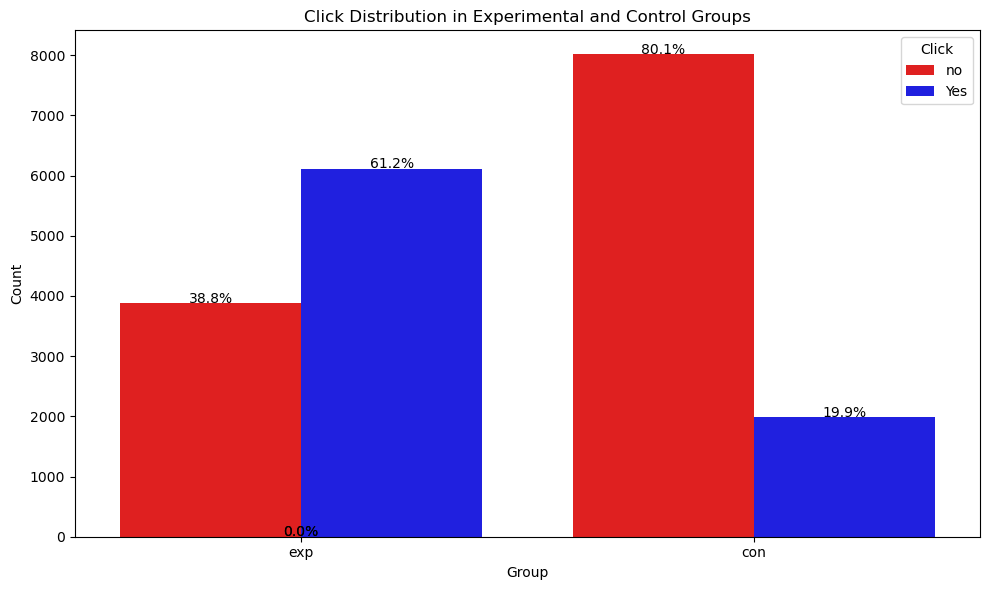

In [11]:
palette = {0: 'red', 1: 'blue'}

plt.figure(figsize=(10,6))
ax = sns.countplot(x='group', hue='click', data=df, palette=palette)
plt.title("Click Distribution in Experimental and Control Groups")
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title="Click", labels=["no", "Yes"])

group_counts = df.groupby(['group']).size()
group_click_counts = df.groupby(['group','click']).size().reset_index(name="count")

for p in ax.patches:
    height = p.get_height()
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
alpha = 0.05
print("Alpha: significant level is:", alpha)

delta = 0.1
print("Delta: minimum detectavble effect is:", delta)

Alpha: significant level is: 0.05
Delta: minimum detectavble effect is: 0.1


## Calculating total number of click for each group

In [37]:
N_con = df[df["group"] == "con"].count()
N_exp = df[df["group"] == "exp"].count()

X_con = df.groupby("group")["click"].sum().loc["con"]
X_exp = df.groupby("group")["click"].sum().loc["exp"]

print(df.groupby("group")["click"].sum())
print("Number of Users in control:\n", N_con)
print("Number of Users in Experimental:\n", N_exp)
print("Number of Clicks in control:", X_con)
print("Number of Clicks in Experimental:", X_exp)

group
con    1989
exp    6116
Name: click, dtype: int64
Number of Users in control:
 user_id      10000
click        10000
group        10000
timestamp        0
dtype: int64
Number of Users in Experimental:
 user_id      10000
click        10000
group        10000
timestamp    10000
dtype: int64
Number of Clicks in control: 1989
Number of Clicks in Experimental: 6116


## Calculating Pooled Estimates for Clicks per Group

In [47]:
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)

Click Probability in Control Group: user_id      0.1989
click        0.1989
group        0.1989
timestamp       inf
dtype: float64
Click Probability in Experimental Group: user_id      0.6116
click        0.6116
group        0.6116
timestamp    0.6116
dtype: float64
Pooled Click Probability: user_id      0.40525
click        0.40525
group        0.40525
timestamp    0.81050
dtype: float64


## Calculating Pooled Variance

In [ ]:
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)